In [22]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl

%matplotlib inline   
%matplotlib notebook

# Plot settings
mpl.rcParams['legend.frameon' ] = False
mpl.rcParams['legend.fontsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize' ] = 18
mpl.rcParams['axes.labelsize' ] = 18
mpl.rcParams['lines.linewidth'] = 2.5

In [23]:
featureName = ['FA','VA','CA','RS','Ch','FS','TS','De','pH','Su','Al','Q']
mydata = pd.read_csv('WhiteWineQuality.csv', sep=";", names=featureName, skiprows=1)
print( mydata.head(10) )

    FA    VA    CA    RS     Ch    FS     TS      De    pH    Su    Al  Q
0  7.0  0.27  0.36  20.7  0.045  45.0  170.0  1.0010  3.00  0.45   8.8  6
1  6.3  0.30  0.34   1.6  0.049  14.0  132.0  0.9940  3.30  0.49   9.5  6
2  8.1  0.28  0.40   6.9  0.050  30.0   97.0  0.9951  3.26  0.44  10.1  6
3  7.2  0.23  0.32   8.5  0.058  47.0  186.0  0.9956  3.19  0.40   9.9  6
4  7.2  0.23  0.32   8.5  0.058  47.0  186.0  0.9956  3.19  0.40   9.9  6
5  8.1  0.28  0.40   6.9  0.050  30.0   97.0  0.9951  3.26  0.44  10.1  6
6  6.2  0.32  0.16   7.0  0.045  30.0  136.0  0.9949  3.18  0.47   9.6  6
7  7.0  0.27  0.36  20.7  0.045  45.0  170.0  1.0010  3.00  0.45   8.8  6
8  6.3  0.30  0.34   1.6  0.049  14.0  132.0  0.9940  3.30  0.49   9.5  6
9  8.1  0.22  0.43   1.5  0.044  28.0  129.0  0.9938  3.22  0.45  11.0  6


<IPython.core.display.Javascript object>


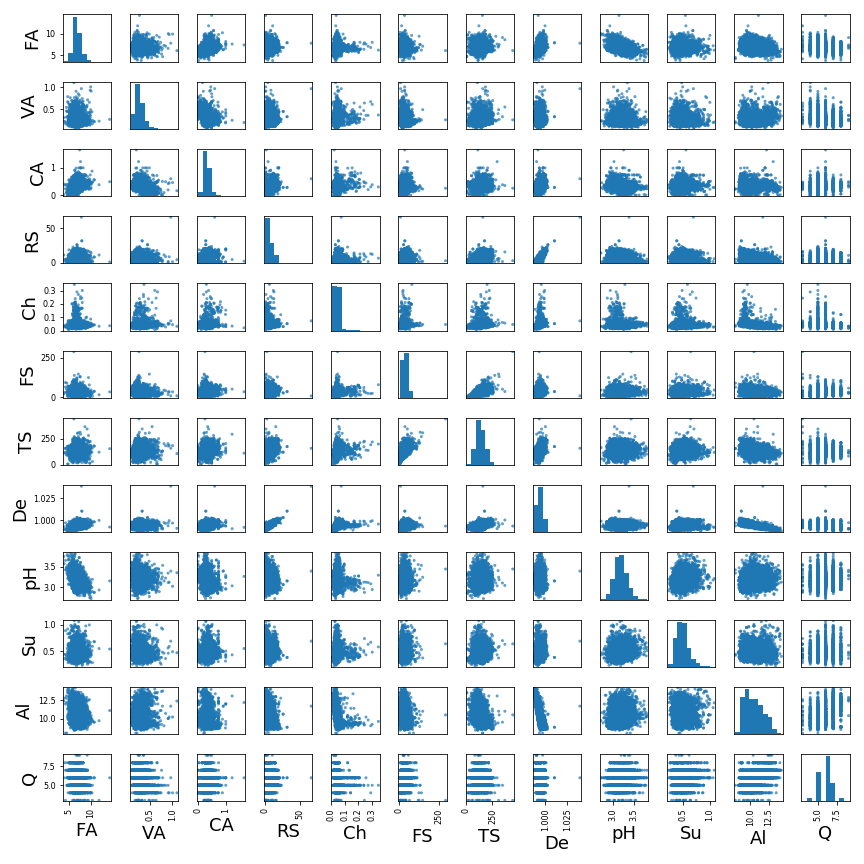

In [24]:
pd.plotting.scatter_matrix(mydata, figsize=(12,12), alpha=0.7, diagonal='hist')
plt.tight_layout()
plt.draw()